In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
# column names for the RNA-seq samples generated for various controls, mutants and siRNAs ...
rsem_si_cols = ['rsem.out.S442_IAA',
                'rsem.out.S442_IAAR2',
                'rsem.out.S442_NT',
                'rsem.out.S442_NTR2',
                'rsem.out.S442_siCTRL_IAAR2',
                'rsem.out.S442_siCTRL_NTR2',
                'rsem.out.S442_siCtrl_IAA',
                'rsem.out.S442_siCtrl_NT',
                'rsem.out.S442_siDDX55_IAA',
                'rsem.out.S442_siDDX55_IAAR2',
                'rsem.out.S442_siDDX55_NT',
                'rsem.out.S442_siDDX55_NTR2',
                'rsem.out.S442_siTAF5L_IAA',
                'rsem.out.S442_siTAF5L_IAAR2',
                'rsem.out.S442_siTAF5L_NT',
                'rsem.out.S442_siTAF5L_NTR2',
                'rsem.out.S44_IAA',
                'rsem.out.S44_IAAR2',
                'rsem.out.S44_NT',
                'rsem.out.S44_NTR2']
rsem_mut_cols = ['rsem.out.AAVS1_sg24_IAA',
                'rsem.out.AAVS1_sg24_IAAR2',
                'rsem.out.AAVS1_sg24_NT',
                'rsem.out.AAVS1_sg24_NTR2',
                'rsem.out.DDX55_sg27_IAA',
                'rsem.out.DDX55_sg27_IAAR2',
                'rsem.out.DDX55_sg27_NT',
                'rsem.out.DDX55_sg27_NTR2',
                'rsem.out.DDX55_sg2B_IAA',
                'rsem.out.DDX55_sg2B_IAAR2',
                'rsem.out.DDX55_sg2B_NT',
                'rsem.out.DDX55_sg2B_NTR2',
                'rsem.out.TAF5L_sg23_IAA',
                'rsem.out.TAF5L_sg23_IAAR2',
                'rsem.out.TAF5L_sg23_NT',
                'rsem.out.TAF5L_sg23_NTR2',
                'rsem.out.TAF5L_sg27_IAA',
                'rsem.out.TAF5L_sg27_IAAR2',
                'rsem.out.TAF5L_sg27_NT',
                'rsem.out.TAF5L_sg27_NTR2']

In [6]:
rsem_si_df = pd.read_csv("merged_TPM_genes_si.tsv",sep="\t")[["Id"] + rsem_si_cols]
rsem_mut_df = pd.read_csv("merged_TPM_genes_mut.tsv",sep="\t")[["Id"] + rsem_mut_cols]

# merge si and mut parts to create a monster RNA-seq data set ...
rsem_df = pd.merge(rsem_si_df,rsem_mut_df,how="inner",on="Id")

# some checks
assert np.asarray([(c in rsem_df.columns) for c in rsem_mut_cols]).all()
assert np.asarray([(c in rsem_df.columns) for c in rsem_si_cols]).all()
assert len(rsem_df) == len(rsem_si_df) == len(rsem_mut_df)


#### We'll be using minimum and maximum levels of RNA-seq per gene across samples to define our lists of "commonly" active and inactive genes - so let's calculate min/max and drop all other columns ...

Text(0, 0.5, 'min-TPM')

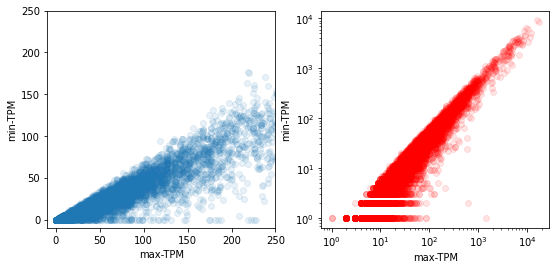

In [7]:
# explore a bit how min vs max behave ...
# are there a lot of genes that go from expressed to not expressed etc ...
_max_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].max(axis=1)
_min_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].min(axis=1)

x = _max_col
y = _min_col

f,axs = plt.subplots(1,2,figsize=(9,4))
ax = axs[0]
ax.scatter(x,y,alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")
ax.set_xlim((-10,250))
ax.set_ylim((-10,250))
ax = axs[1]
ax.loglog(x,y,"ro",alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")

In [8]:
rsem_df = rsem_df[["Id"]]
rsem_df["exp_min"] = _min_col
rsem_df["exp_max"] = _max_col

#### Overlap that refined dataframe of RNA-seq results with "our" list of genes ...

In [9]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

,Id,exp_min,exp_max,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4273,7092,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,12,21,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [10]:
# refine the dataframe  ...
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "exp_min", "exp_max"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [11]:
# final adjustments ...
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp_min,exp_max,size
0,chr1,11873,14409,+,0,0,2536
1,chr1,14361,29370,-,28,56,15009
2,chr1,69090,70008,+,0,0,918


In [12]:
all_genes = copy(gdf)

#### Let's try to remove genes with CTCF at the promoters(TSS) and TTS - just in case

In [13]:
from copy import copy
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)

# .drop_duplicates(subset=["chrom_","tss_mflank_","tss_pflank_"])

In [14]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

5063 genes have CTCF@TSS,
    17231 genes do not -
    total # of genes 22294


#### same for TTS ...

In [15]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

2568 genes have CTCF@TTS,
    19726 genes do not -
    total # of genes 22294


#### Combine "exclusion" of CTCF for both TSS and TTS ...

In [16]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

15710 genes have no CTCF@TTS and no CTCF@TSS


### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [17]:
gdf = copy(all_genes_noctcf_atall)

In [18]:
fig5_samples = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "ev1_CTCF",
                "ev1_noCTCF",
                "ev1_polII",
                "ev1_nopolII",
                "polII",
                'h3k4_r1',
                "mrna_ctcf",
                "mrna_noctcf"]

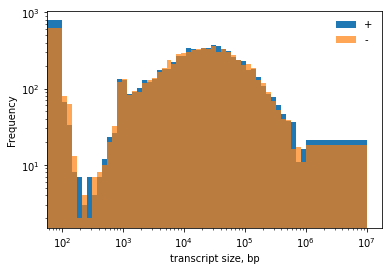

In [19]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

Text(0.5, 1.0, 'max')

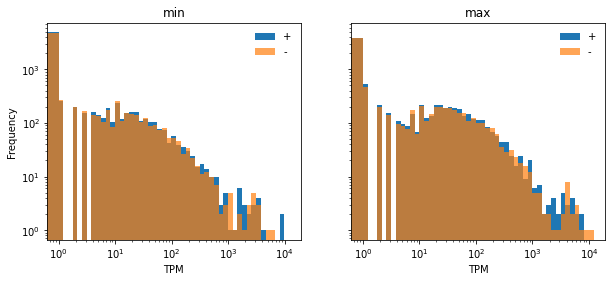

In [20]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
f,axs = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax = axs[0]
gdf[gdf["strand"]=="+"]["exp_min"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_min"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("min")
ax = axs[1]
gdf[gdf["strand"]=="+"]["exp_max"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_max"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("max")

In [21]:
exp_bin_edges = [0,.5,5,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp_min"] = pd.cut(
    gdf["exp_min"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gexp_max"] = pd.cut(
    gdf["exp_max"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head(2))
display( gdf.groupby(["gexp_min","gsize"]).size().unstack(fill_value=0) )
# finding the common active genes and common inactive ones ...
display( gdf.groupby(["gexp_min","gexp_max","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp_min,exp_max,size,gexp_min,gexp_max,gsize
0,chr1,14361,29370,-,28,56,15009,high,high,short
1,chr1,69090,70008,+,0,0,918,no,no,short


gsize,short,long
gexp_min,,
no,7766,1915
low,1065,747
high,2875,1342


gsize              short  long
gexp_min gexp_max             
no       no         6319  1360
         low        1261   489
         high        186    66
low      no            0     0
         low         187   146
         high        878   601
high     no            0     0
         low           0     0
         high       2875  1342

In [22]:
long_high_genes = gdf.groupby(["gexp_min","gexp_max","gsize"]).get_group(("high","high","long"))

In [23]:
TSS_TTS_ints = pd.DataFrame({})
TSS_TTS_ints["chrom1"] = long_high_genes["chrom"].copy()
TSS_TTS_ints["start1"] = long_high_genes["start"].copy() - 5  # 10 bp-wide peak
TSS_TTS_ints["end1"] = long_high_genes["start"].copy() + 5  # 10 bp-wide peak

TSS_TTS_ints["chrom2"] = long_high_genes["chrom"].copy()
TSS_TTS_ints["start2"] = long_high_genes["end"].copy() - 5  # 10 bp-wide peak
TSS_TTS_ints["end2"] = long_high_genes["end"].copy() + 5  # 10 bp-wide peak

TSS_TTS_ints["strand"] = long_high_genes["strand"]

In [24]:
TSS_TTS_ints

,chrom1,start1,end1,chrom2,start2,end2,strand
37,chr1,1716718,1716728,chr1,1822551,1822561,-
66,chr1,6324326,6324336,chr1,6453822,6453832,-
72,chr1,6845378,6845388,chr1,7829761,7829771,+
74,chr1,7844345,7844355,chr1,7905232,7905242,+
87,chr1,9788978,9788988,chr1,9884579,9884589,-
...,...,...,...,...,...,...,...
15617,chr9,134249032,134249042,chr9,134375575,134375585,+
15619,chr9,134735493,134735503,chr9,134955249,134955259,-
15623,chr9,135468378,135468388,chr9,135545783,135545793,-
15671,chr9,138700327,138700337,chr9,138799387,138799397,-


In [ ]:
TSS_TTS_ints.to_csv("",sep="\t",index=False,header=False")

## take these start and ends and turn them into "interactions" in the form of a BEDPE file 